In [ ]:
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/My Drive/tutorial2/FruitinAmazon/train/"
test_dir = "/content/drive/My Drive/tutorial2/FruitinAmazon/test/"


# Task 1: Data Understanding and Visualization:

1. Load and visualize images from a dataset stored in directories, where each subdirec-
tory represents a class. You are expected to write a code:


• Get the list of class directories from the train folder.

• Select one image randomly from each class.

• Display the images in a grid format with two rows using matplotlib.

In [ ]:
# Get the list of class directories
class_names = sorted(os.listdir(train_dir))
print("Classes found:", class_names)


Classes found: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [ ]:
# Select one image randomly from each class
selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_path)

    if len(image_files) > 0:
        random_image = random.choice(image_files)
        img_path = os.path.join(class_path, random_image)

        img = Image.open(img_path).convert("RGB")  # Convert to RGB format
        img = img.resize((100, 100))  # Resize for visualization

        selected_images.append(np.array(img))
        selected_labels.append(class_name)


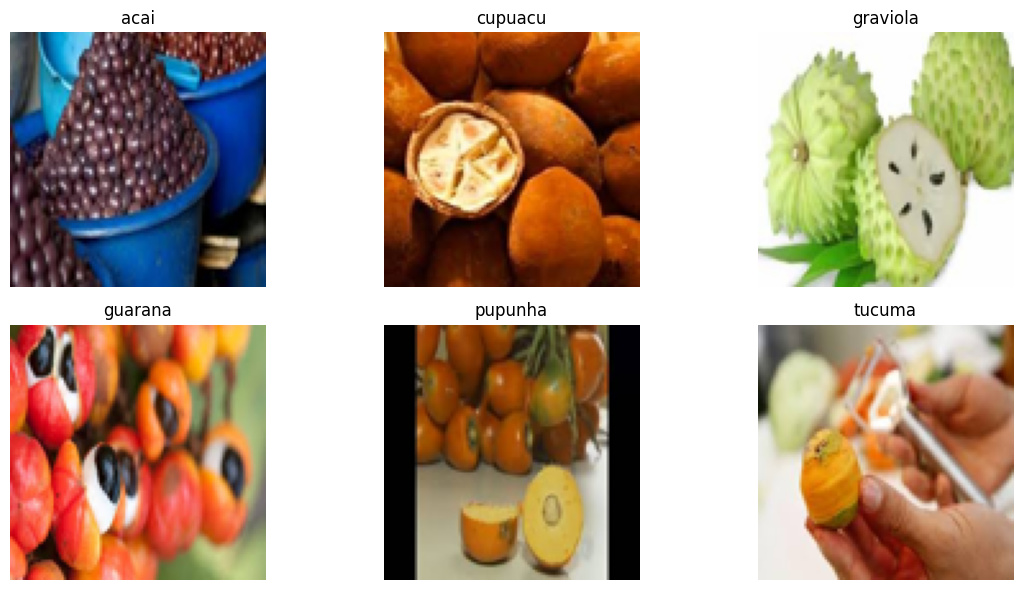

In [ ]:
# Plot images in a grid format with two rows
fig, axes = plt.subplots(nrows=2, ncols=len(selected_images)//2, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i])
    ax.set_title(selected_labels[i])
    ax.axis("off")

plt.tight_layout()
plt.show()


**2. Check for Corrupted Image:**

Write a script that verifies whether the image in the train
directory are valid. If any corrupted images are found, the script must remove the image from
the directory and print the message which image have been removed, if none found print ”No
Corrupted Images Found.

In [ ]:
def remove_corrupted_images(directory):
    corrupted_images = []  # List to store corrupted image paths

    # Iterate through each class folder
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)

        if not os.path.isdir(class_path):  # Skip non-folder files
            continue

        # Iterate through all images in the class folder
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            try:
                # Try opening the image
                with Image.open(img_path) as img:
                    img.verify()  # Verify the image is valid

            except (IOError, SyntaxError):  # Catch corrupted images
                corrupted_images.append(img_path)
                os.remove(img_path)  # Delete the corrupted image
                print(f"Removed corrupted image: {img_path}")

    # Print final summary
    if corrupted_images:
        print(f"\nTotal {len(corrupted_images)} corrupted images removed.")
    else:
        print("No corrupted images found.")


In [ ]:
remove_corrupted_images(train_dir)


No corrupted images found.


# Task 2: Loading and Preprocessing Image Data in keras:

In [ ]:
# Define image size and batch size
img_height = 224 # Example image height
img_width = 224 # Example image width
batch_size = 32
validation_split = 0.2 # 80% training, 20% validation

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255) # Normalize pixel values to [0, 1]

# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      labels='inferred',
      label_mode='int',
      image_size=(img_height, img_width),
      interpolation='nearest',
      batch_size=batch_size,
      shuffle=True,
      validation_split=validation_split,
      subset='training',
      seed=123
)

# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=False,
  validation_split=validation_split,
  subset='validation',
  seed=123
)
# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


# Task 3 - Implement a CNN with and Compile the Model

In [ ]:
# # Define number of output classes
num_classes = 6  # Change based on dataset


# Define the model
model = keras.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1, input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2), strides=2),

    # Convolutional Layer 2
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
    layers.MaxPooling2D((2, 2), strides=2),

    # Flatten Layer to convert 3D output of convolution to 1D input for dense layers
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')  # num_classes based on your dataset
])

# Compile the model with Adam optimizer, sparse categorical crossentropy, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary to see the input-output shapes at each layer
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,441,830 (24.57 MB)

 Trainable params: 6,441,830 (24.57 MB)

 Non-trainable params: 0 (0.00 B)

# Task 4: Train the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=250,  # Number of epochs
    batch_size=16,  # Batch size
    callbacks=[checkpoint_cb, early_stopping_cb]  # Callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1539 - loss: 1.7882

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1606 - loss: 1.7877 - val_accuracy: 0.0000e+00 - val_loss: 1.8353
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1794 - loss: 1.7460

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1832 - loss: 1.7459 - val_accuracy: 0.0556 - val_loss: 1.8230
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2365 - loss: 1.6823 - val_accuracy: 0.1667 - val_loss: 1.8654
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2546 - loss: 1.6224

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2569 - loss: 1.6096 - val_accuracy: 0.5000 - val_loss: 1.3649
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4753 - loss: 1.4141 - val_accuracy: 0.1667 - val_loss: 1.9513
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3307 - loss: 1.6187 - val_accuracy: 0.5556 - val_loss: 1.5002
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4641 - loss: 1.2599

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4696 - loss: 1.2686 - val_accuracy: 0.4444 - val_loss: 1.2130
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5642 - loss: 1.0422

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5690 - loss: 1.0452 - val_accuracy: 0.7778 - val_loss: 1.0387
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6359 - loss: 0.9131 - val_accuracy: 0.3333 - val_loss: 1.2568
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6055 - loss: 1.1458 - val_accuracy: 0.7778 - val_loss: 1.0918
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7216 - loss: 0.7300

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7114 - loss: 0.7380 - val_accuracy: 0.7778 - val_loss: 0.9363
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8142 - loss: 0.7811

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8190 - loss: 0.7557 - val_accuracy: 0.7778 - val_loss: 0.6658
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9223 - loss: 0.3399 - val_accuracy: 0.7778 - val_loss: 0.9233
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9488 - loss: 0.2202 - val_accuracy: 0.8333 - val_loss: 0.6873
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8304 - loss: 0.6175

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8277 - loss: 0.6123 - val_accuracy: 0.8333 - val_loss: 0.4991
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8116 - loss: 1.4847 - val_accuracy: 0.7222 - val_loss: 1.0433
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7491 - loss: 0.8355 - val_accuracy: 0.5000 - val_loss: 1.3013
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8090 - loss: 0.7166 - val_accuracy: 0.8889 - val_loss: 0.5499
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8533 - loss: 0.4104 - val_accuracy: 0.6111 - val_loss: 2.0004
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8472 - loss: 0.5655

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8333 - loss: 0.6232 - val_accuracy: 0.8889 - val_loss: 0.2359
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5343 - loss: 2.1956 - val_accuracy: 0.7778 - val_loss: 0.9544
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6189 - loss: 1.1101 - val_accuracy: 0.4444 - val_loss: 1.2293
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6441 - loss: 1.0744 - val_accuracy: 0.3333 - val_loss: 1.7255
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5790 - loss: 1.1871 - val_accuracy: 0.8889 - val_loss: 0.5200
Epoch 25/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8702 - loss: 0.6388 - val_accuracy: 0.7778 - val_loss: 0.5562
Epoch 26/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9162 - loss: 0.3042 - val_accuracy: 0.6111 - val_loss: 1.6430
Epoch 27/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8190 - loss: 0.6832 - val_accuracy: 0.3889 - val_loss: 2.9200
Epoch 28/250

# Task 5: Evaluate the Model

In [ ]:
# Evaluate the model on the test set
dataset_test = "/content/drive/My Drive/tutorial2/FruitinAmazon/test/"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_test,  # Directory with test data
    image_size=(224, 224),
    batch_size=16
)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


Found 30 files belonging to 6 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.3042 - loss: 978.0792
Test Loss: 951.6294555664062
Test Accuracy: 0.30000001192092896


# Task 6: Save and Load the Model

In [ ]:
# Save the model in the new Keras format
model.save('my_model.keras')

In [ ]:
# Load the saved model in the new Keras format
loaded_model = tf.keras.models.load_model('my_model.keras')

# Re-evaluate the loaded model on the test set
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded Model - Test Loss: {loaded_test_loss}")
print(f"Loaded Model - Test Accuracy: {loaded_test_acc}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.2625 - loss: 1001.5482
Loaded Model - Test Loss: 951.6295166015625
Loaded Model - Test Accuracy: 0.30000001192092896


# Task 7: Predictions and Classification Report

In [ ]:
from sklearn.metrics import classification_report
# Make predictions
predictions = model.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)

# Get true labels
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Generate the classification report
report = classification_report(true_labels, predicted_labels)
print(report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.33      0.20      0.25         5
           4       0.00      0.00      0.00         5
           5       0.16      0.80      0.27         5

    accuracy                           0.17        30
   macro avg       0.08      0.17      0.09        30
weighted avg       0.08      0.17      0.09        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Visualization:

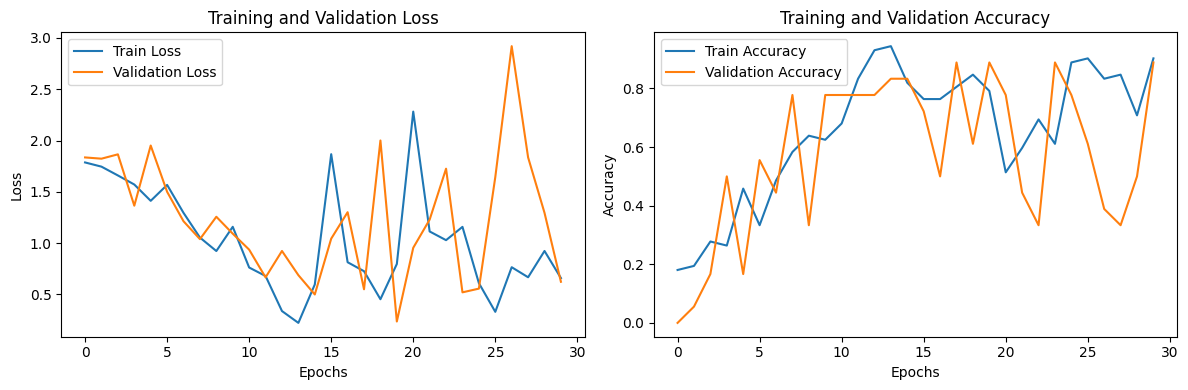

In [ ]:
# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()